# Weight tracking, analysis and forecast

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import datetime
from datetime import date

from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [2]:
print(f'Python = {sys.version}')
print(f'Numpy = {np.__version__}')
print(f'Tensorflow = {tf.__version__}')

Python = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Numpy = 1.20.3
Tensorflow = 2.5.0


In [3]:
import weightlib as wl

# Data Extraction

=> file "data_BEN.zip" contains the file "weight.csv" with all daily measurements of total mass, fat mass.

=> file "Suivi_Poids.csv" has manually-entered daily numbers for total mass and fat mass, plus nutrition data (lipid, carbs, proteines), and calories data (ingested, spent with cardio, spent with strength training)

In [4]:
ROOT = os.getcwd() + '/'
print(f'current working directory is {ROOT}')
print(f'contains :')
print(f'{os.listdir(ROOT)}')

current working directory is c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/
contains :
['.git', '.ipynb_checkpoints', 'data_BEN.zip', 'desktop.ini', 'figure.jpg', 'model.png', 'pat.txt', 'polar-user-data-export.zip', 'README.md', 'Suivi_Poids.csv', 'test_methodes.xlsx', 'tmp', 'weight.ipynb', 'weightlib.py', 'weight_arima.ipynb', 'weight_rapport.ipynb', 'weight_recherche.ipynb', '__pycache__']


In [5]:
ds = wl.GetData(ROOT + 'data_BEN.zip', ROOT + 'Suivi_Poids.csv')

In [6]:
ds.extract()

Extraction fichier Zip Healthmate dans c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/tmp...
... Done


# Basic display of data

We want :
- display of total mass over time, along with average over n days, and regression over m days
- idem for fat mass, body fat percentage
- display of calories, calories exercices, net cals, etc over time, along with average over n days

# Plot de toutes les données depuis 2020

In [7]:
window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date(2020,9,1), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date(2020,9,1), end_date = datetime.date.today() )

graph = wl.Display(window_daily_mass_measurements, window_daily_data)

In [8]:
n_reg_list = [7, 15, 30]

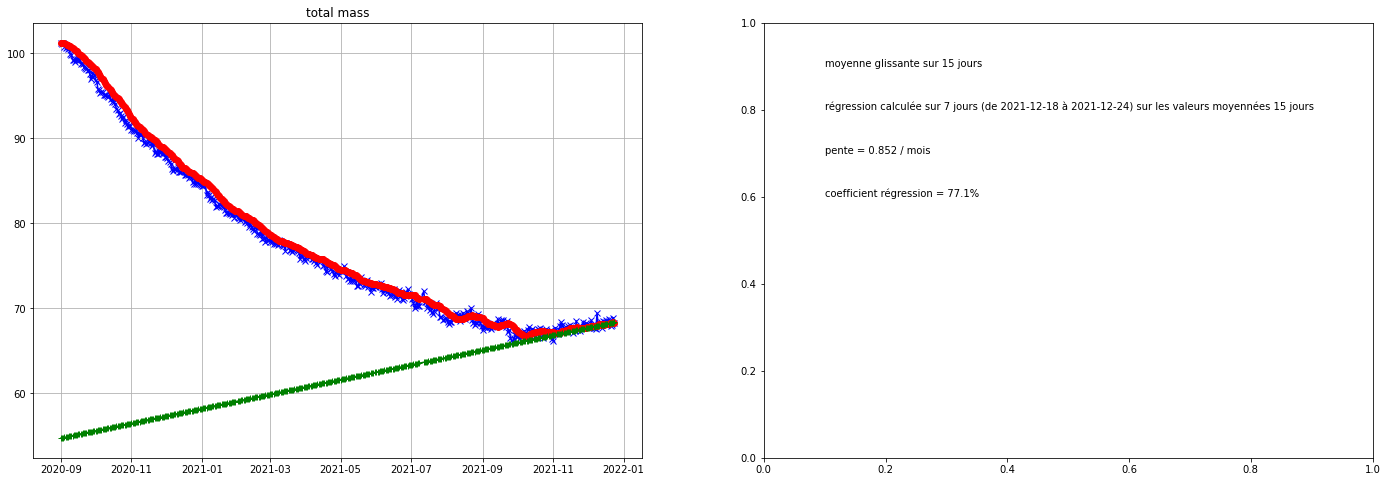

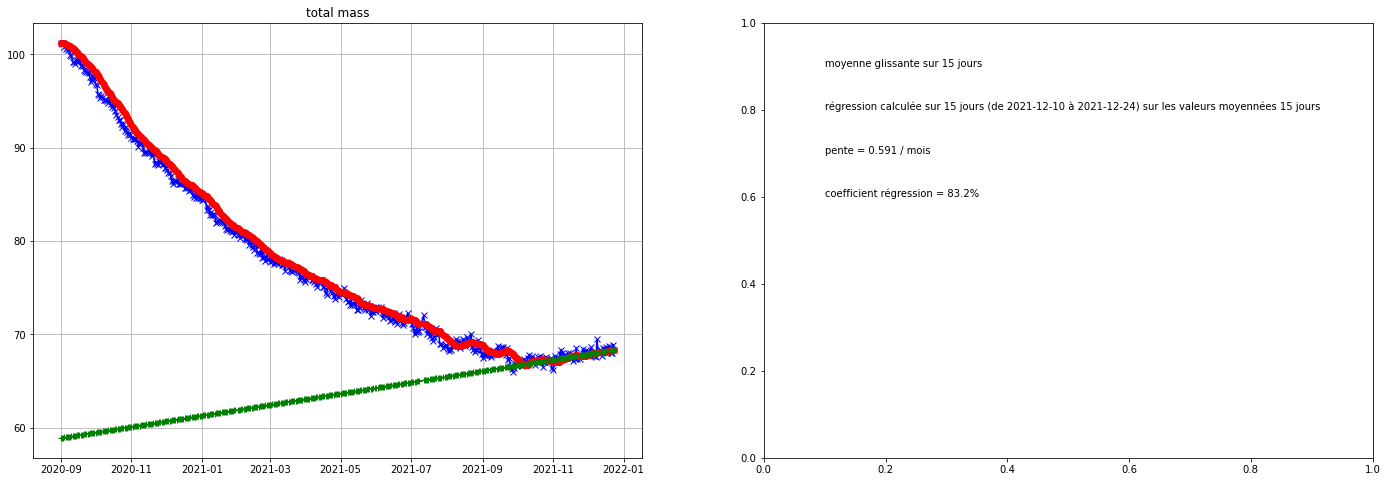

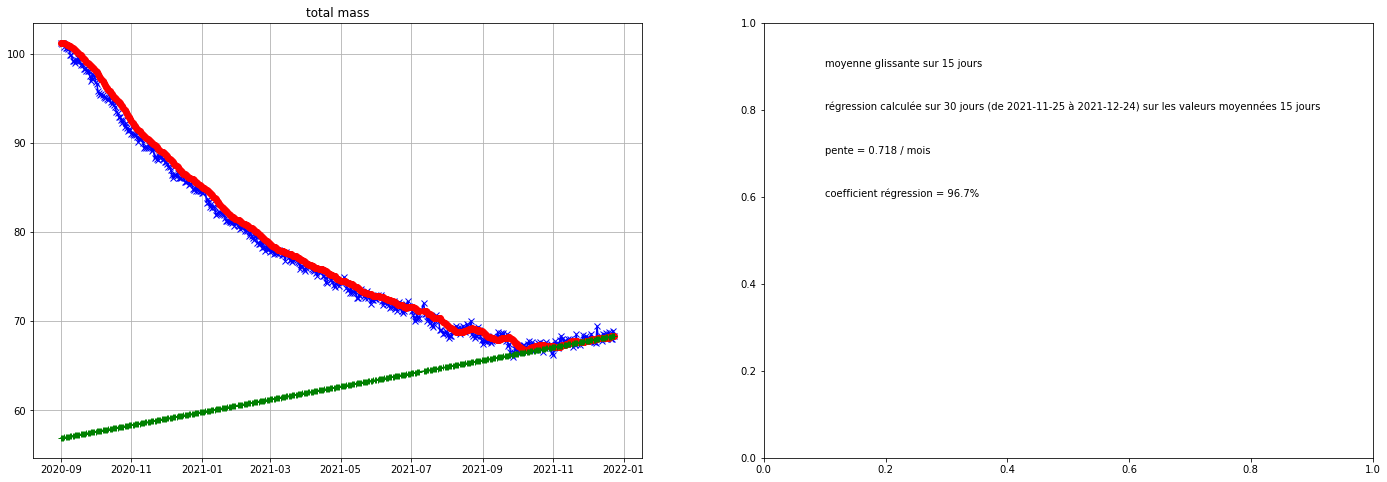

In [9]:
for n_reg in n_reg_list:
    graph.plot_weight(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

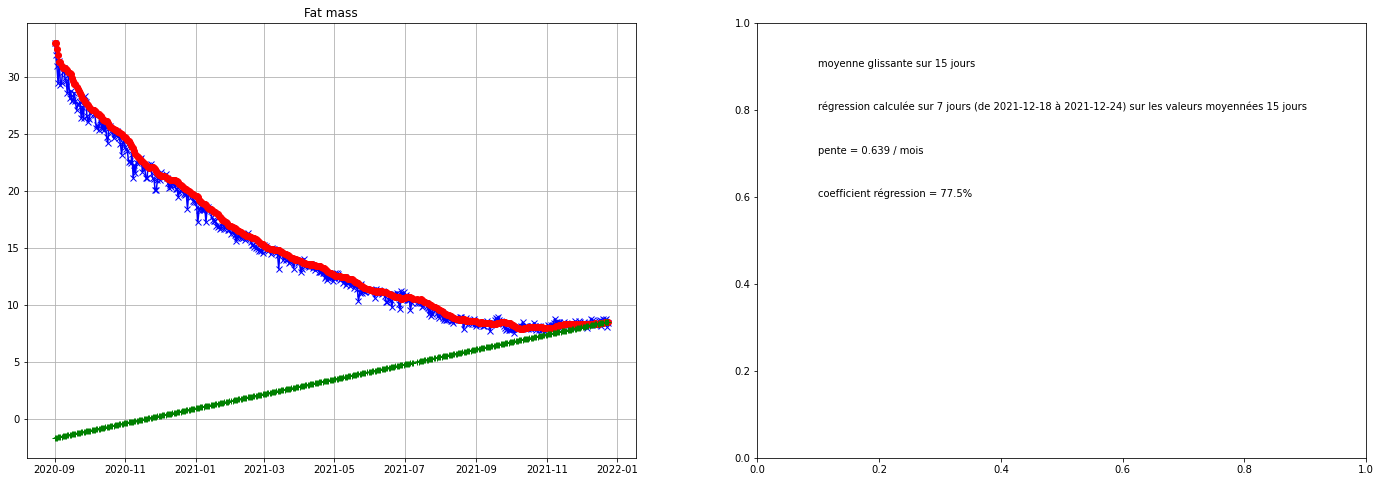

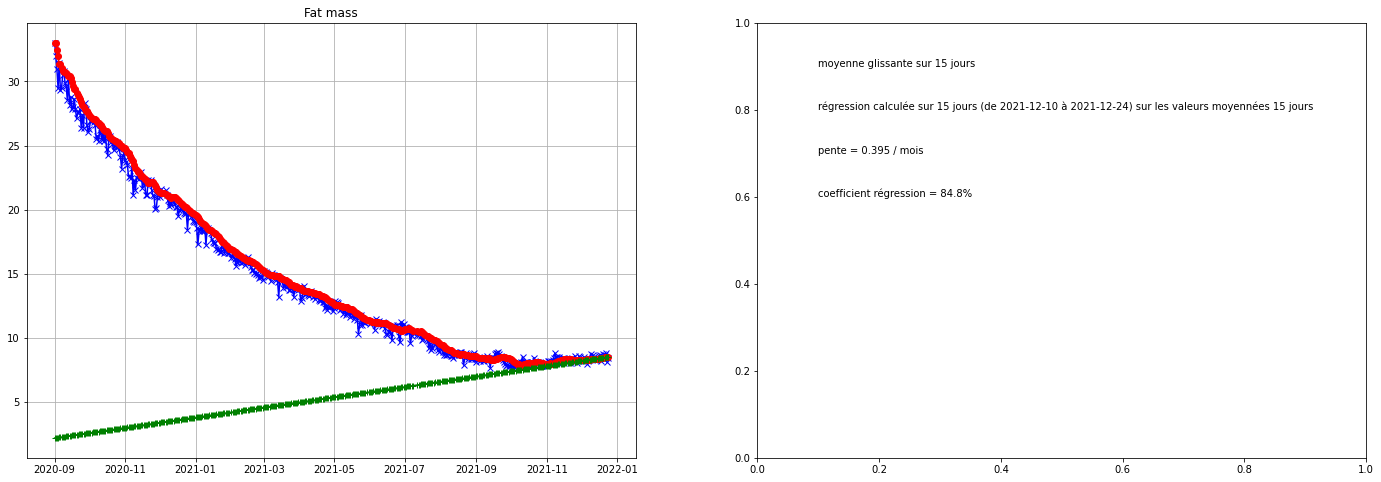

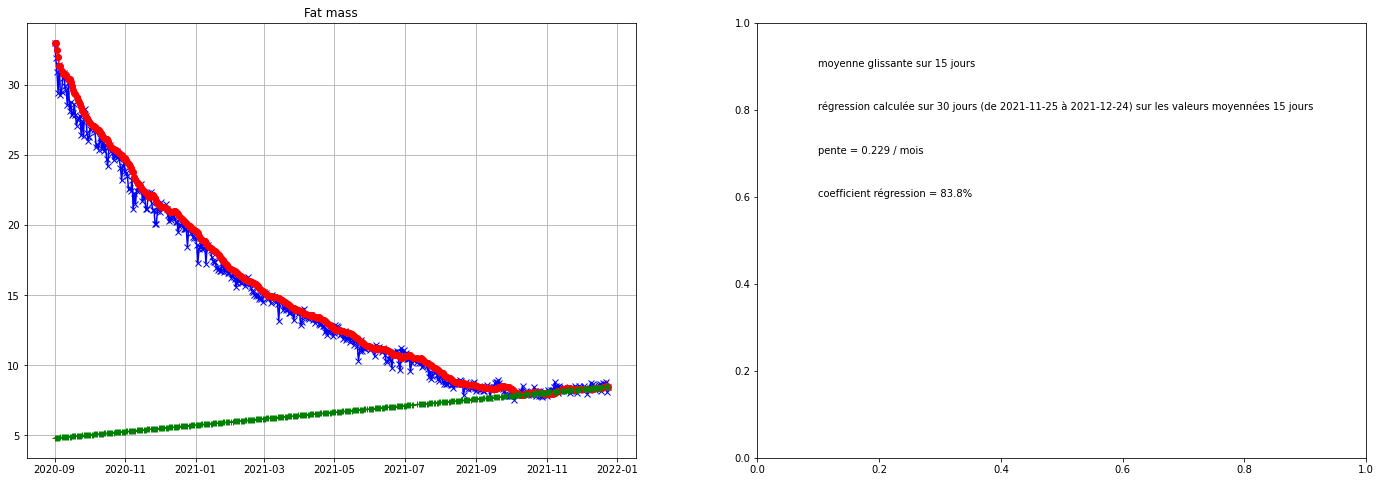

In [10]:
for n_reg in n_reg_list:
    graph.plot_fat(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

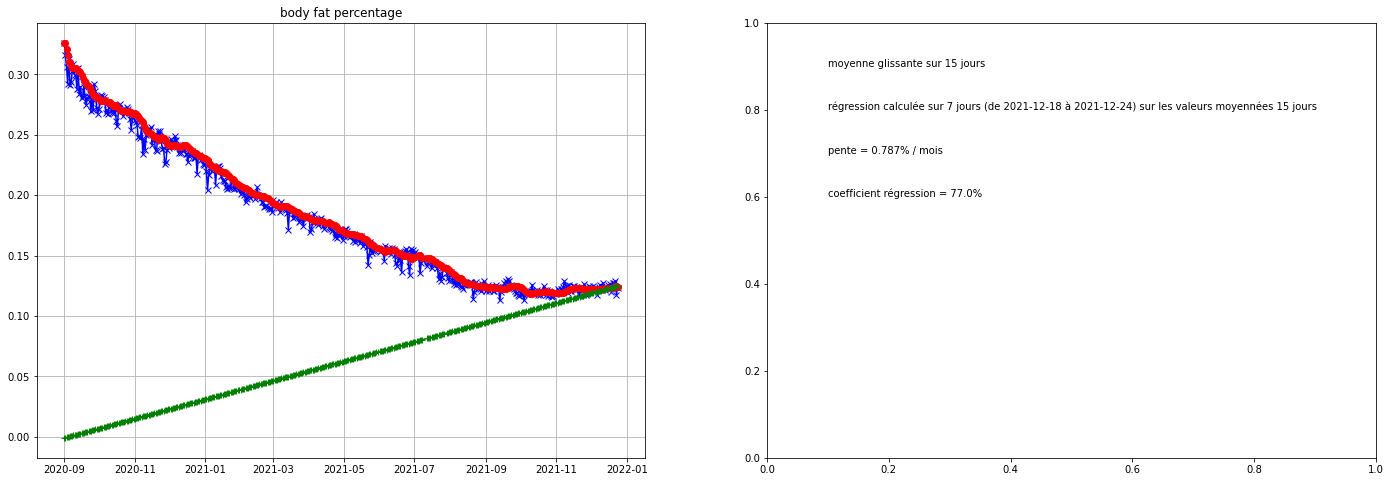

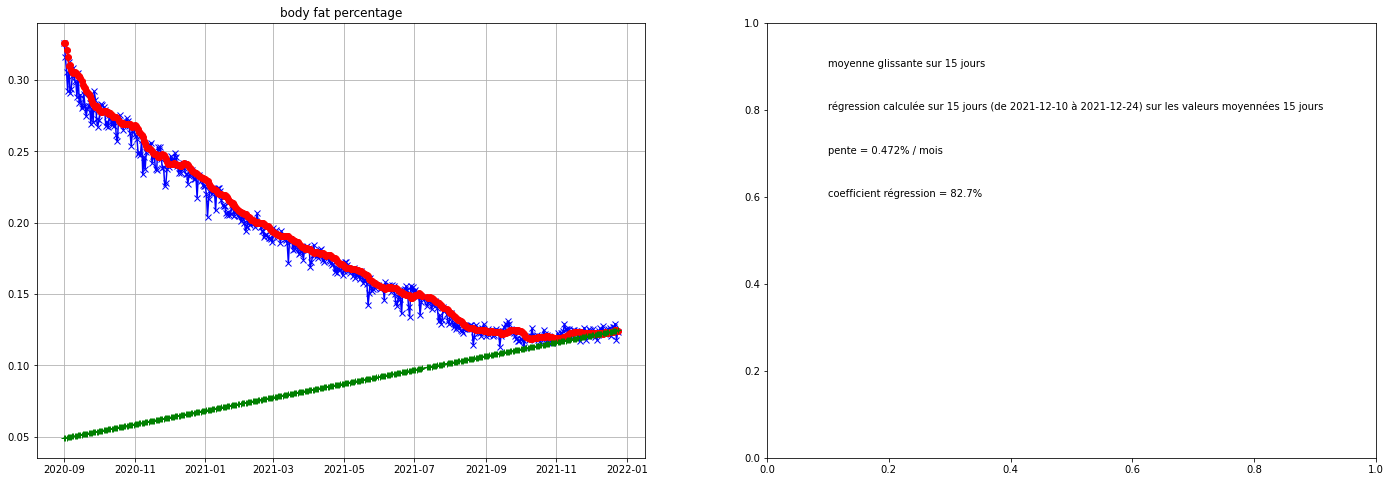

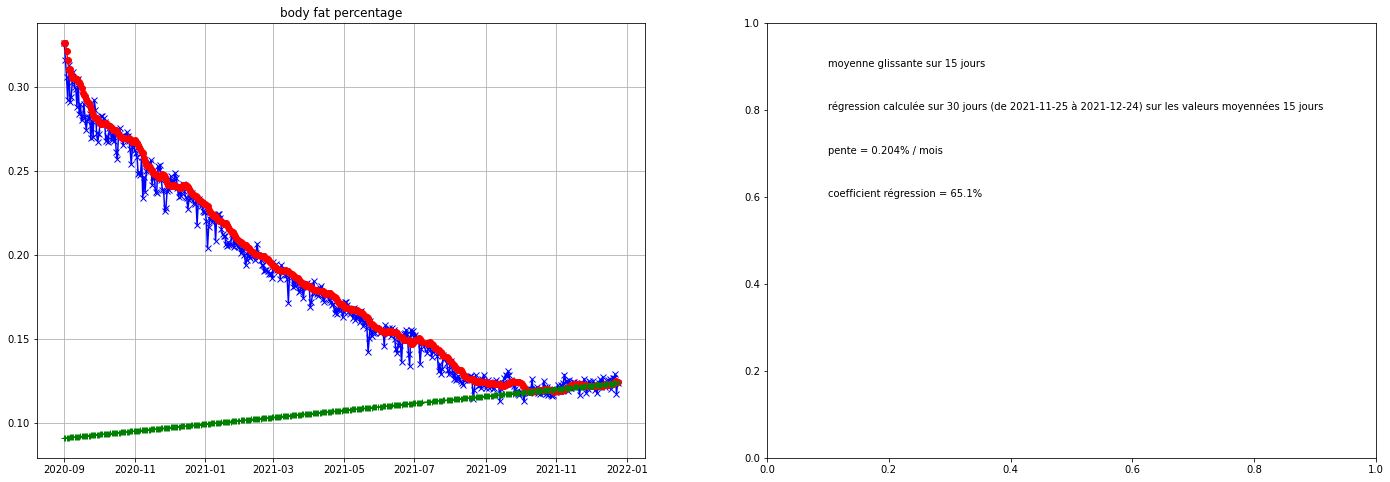

In [11]:
for n_reg in n_reg_list:
    graph.plot_body_fat_percentage(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

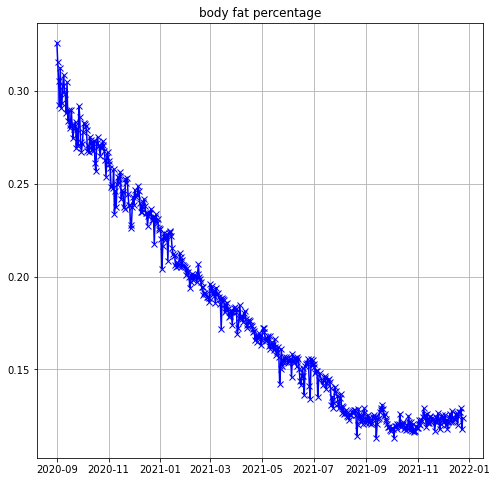

In [12]:
graph.plot_body_fat_percentage(rolling_average=False, n_avg=15, linear_regression=False, n_reg=n_reg)

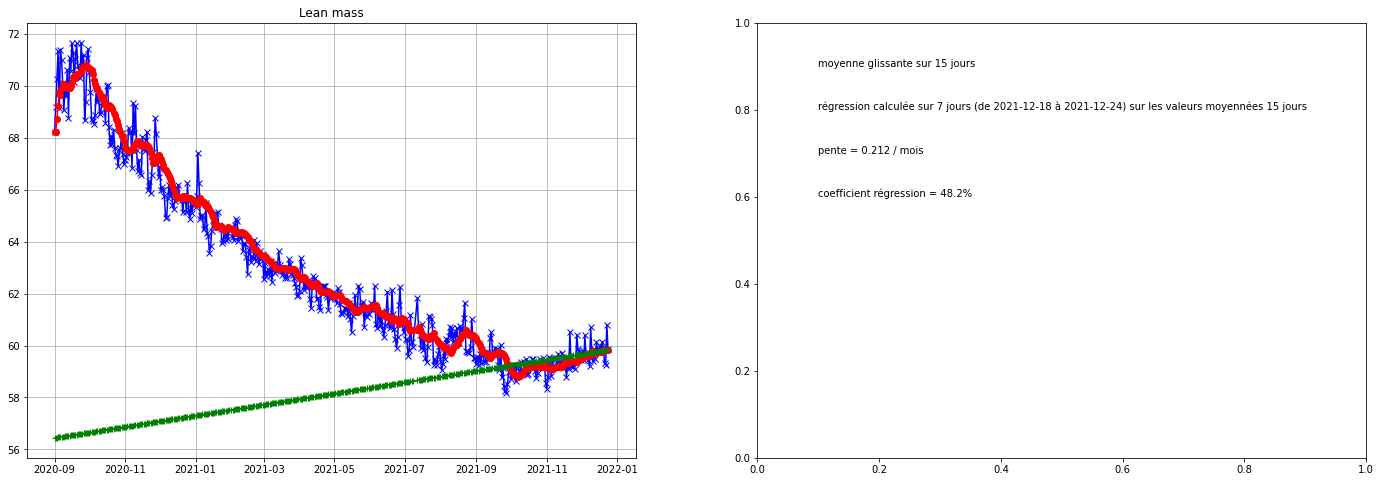

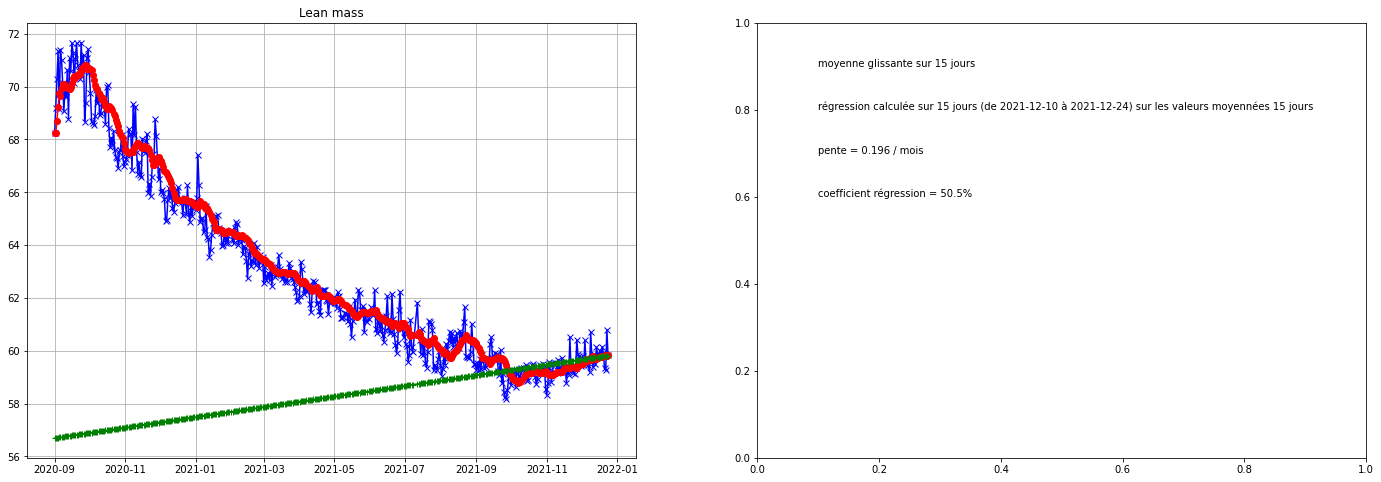

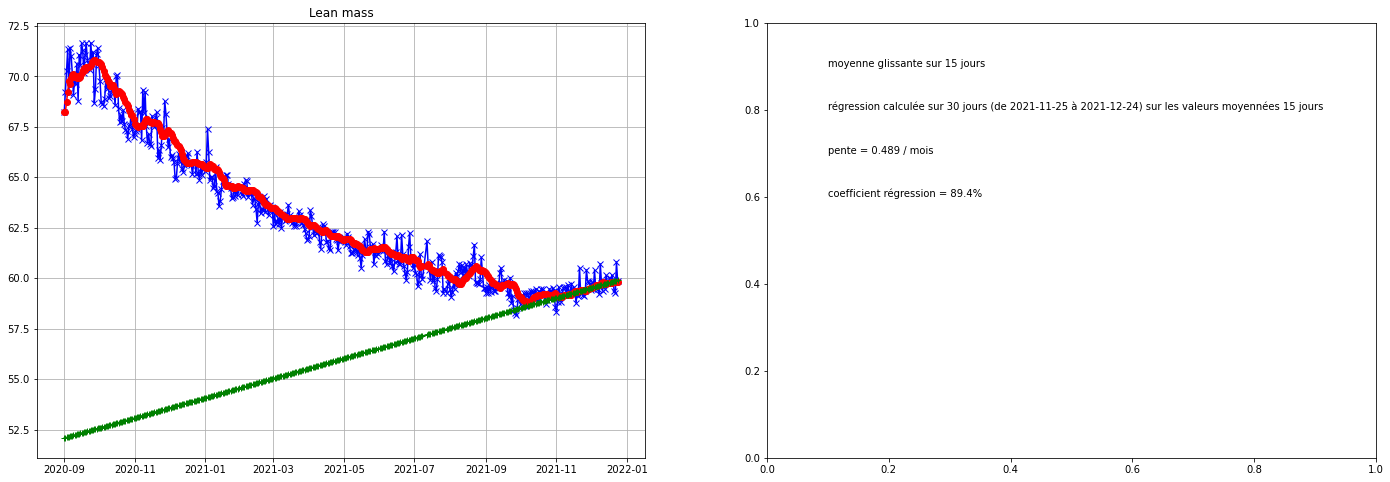

In [13]:
for n_reg in n_reg_list:
    graph.plot_lean_mass(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

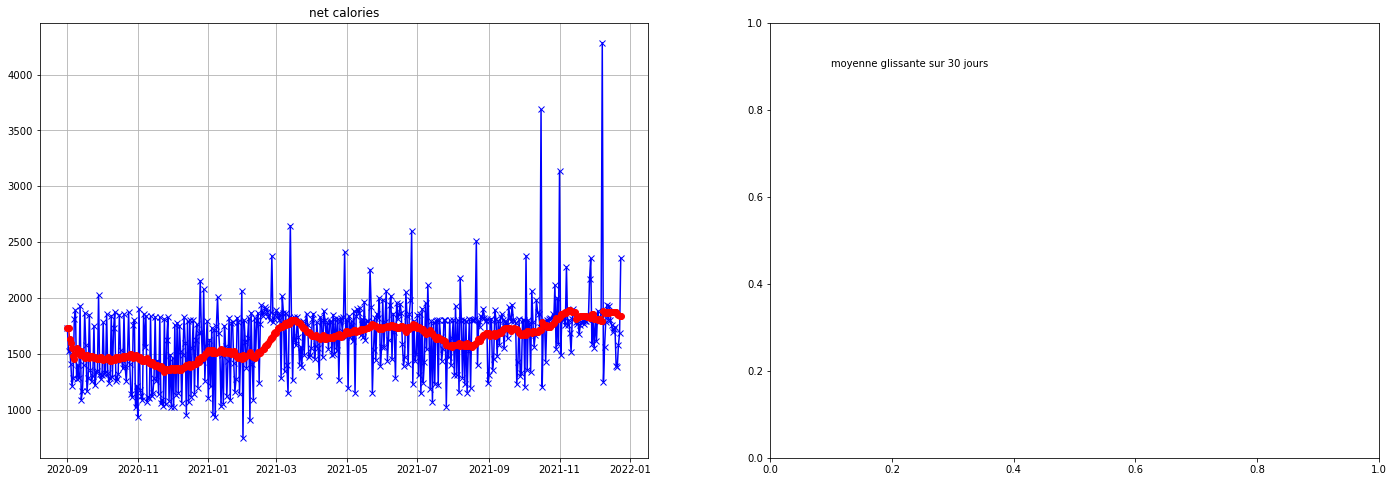

In [14]:
graph.plot_calories_net(rolling_average=True, n_avg=30)

# Zoom 90 jours

In [15]:
over_last_days = 90

window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )

graph = wl.Display(window_daily_mass_measurements, window_daily_data)

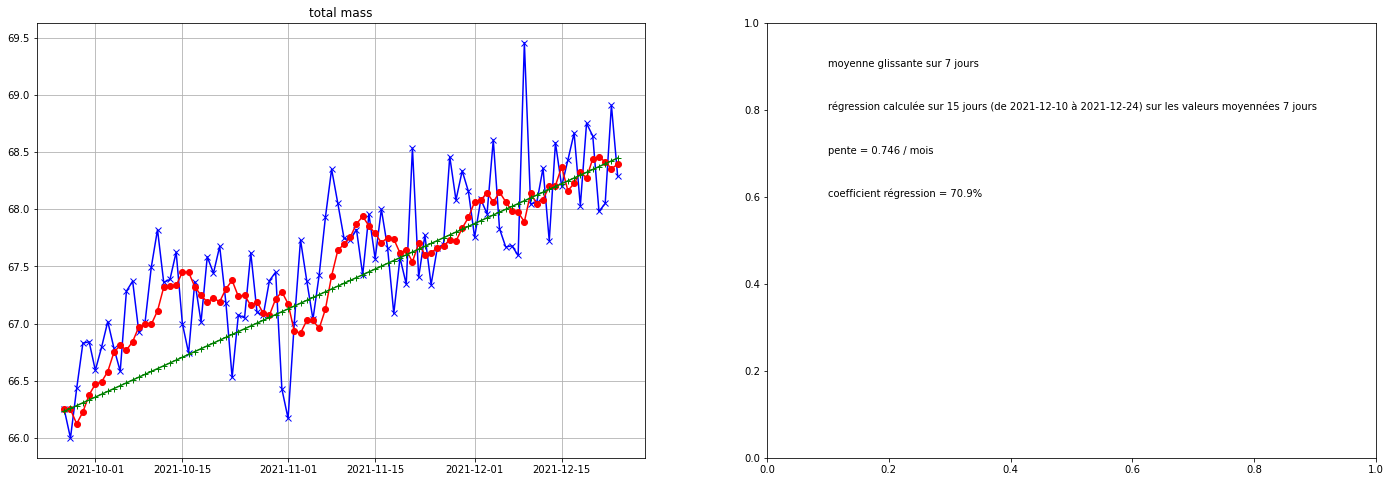

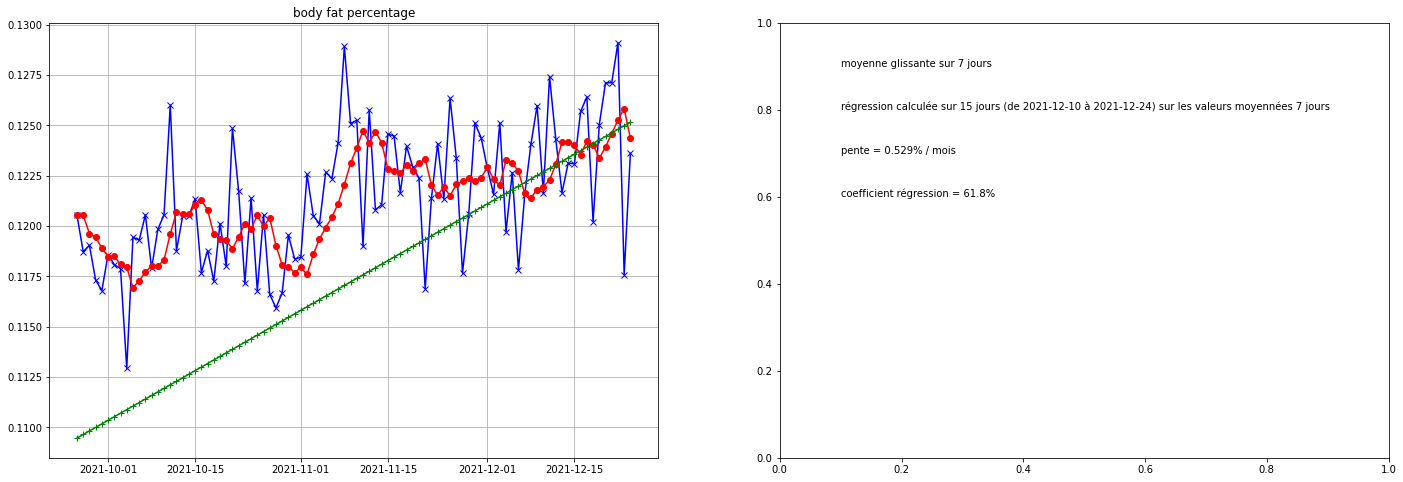

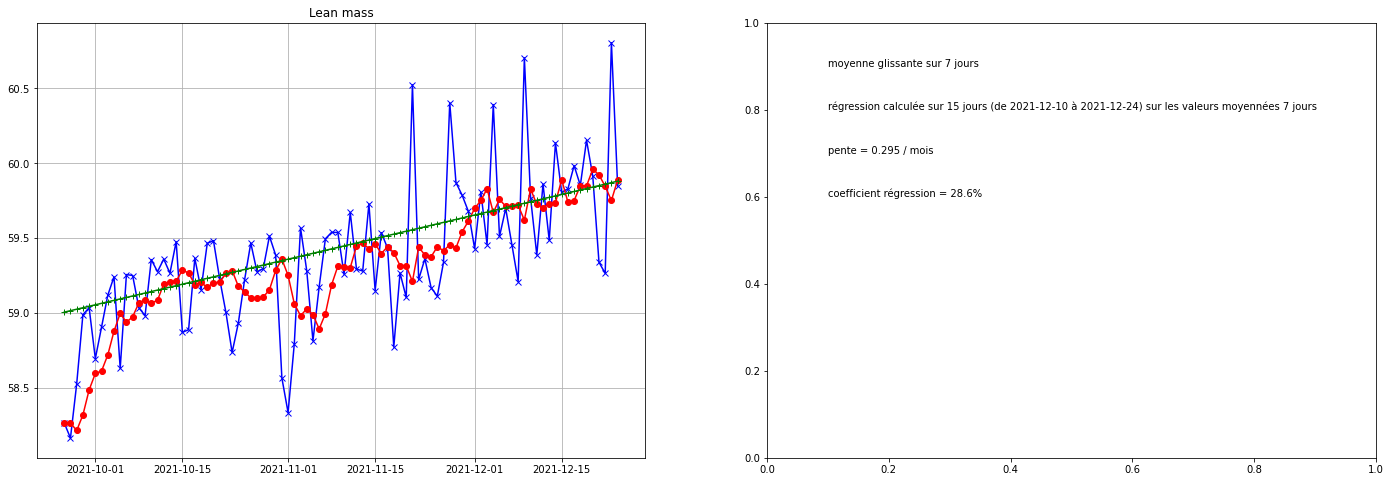

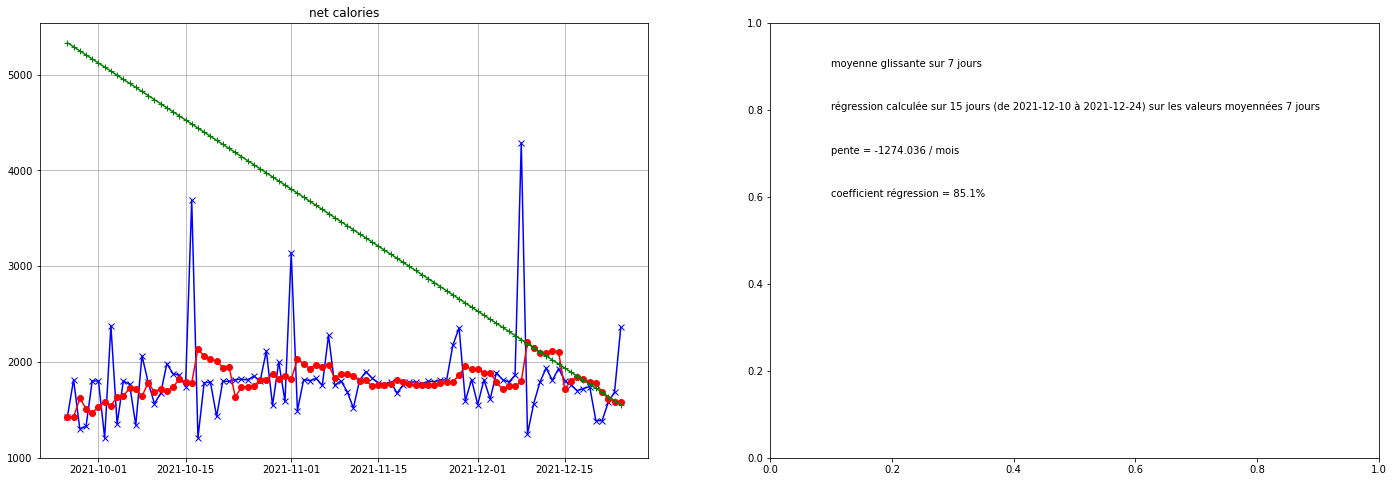

In [16]:
n_reg_list = [15]

for n_reg in n_reg_list:
    graph.plot_weight(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    graph.plot_body_fat_percentage(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    graph.plot_lean_mass(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    
graph.plot_calories_net(rolling_average=True, n_avg=7, linear_regression=True, n_reg=15)


Display depuis dataframe

In [17]:
raw_df = ds.get_dataframe()

raw_df.set_index('date', inplace=True)

In [18]:
df = raw_df

# créée masse_seche
df['masse_seche'] = df['masse_totale'] - df['masse_grasse']

# calories nettes
df['calories_nettes'] = df['calories_in'] - df['calories_exercice']

# body fat percentage
df['bf_perc'] = df['masse_grasse'] / df['masse_totale']

In [19]:
# calcul du métabolisme de base :

df['kma'] = df['masse_seche'].apply(wl.kma)

# df['base_metabolism'] = df[['msj','oxf','sch','kma']].apply(np.mean, axis=1)
df['base_metabolism'] = df['kma']  # on utilise Katch Mac Ardle pour métabolisme de base

df['rest_metabolism'] = df['base_metabolism'] * 1.10  # coefficient adapté de façon à ce que le déficit calorique soit au voisinage de zéro quand les courbes s'inversent entre sèche et bulk

df['calories_deficit'] = df['calories_in'] - df['rest_metabolism'] - df['calories_exercice']

In [20]:
df

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,masse_seche,calories_nettes,bf_perc,kma,base_metabolism,rest_metabolism,calories_deficit
date,,,,,,,,,,,,,,,,
2020-09-01,101.250000,33.020000,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,68.230000,1734.0,0.326123,1843.768000,1843.768000,2028.14480,-294.14480
2020-09-02,101.150000,31.945000,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,69.205000,1523.0,0.315818,1864.828000,1864.828000,2051.31080,-528.31080
2020-09-03,101.200000,30.930000,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,70.270000,1535.0,0.305632,1887.832000,1887.832000,2076.61520,-541.61520
2020-09-04,100.800000,29.460000,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,71.340000,1412.0,0.292262,1910.944000,1910.944000,2102.03840,-690.03840
2020-09-05,100.600000,31.450000,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,69.150000,1211.0,0.312624,1863.640000,1863.640000,2050.00400,-839.00400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-20,68.640000,8.725000,1832.0,181.0,44.0,179.0,446.0,0.0,446.0,59.915000,1386.0,0.127112,1664.164000,1664.164000,1830.58040,-444.58040
2021-12-21,67.980000,8.641000,1791.0,185.0,36.0,176.0,406.0,0.0,406.0,59.339000,1385.0,0.127111,1651.722400,1651.722400,1816.89464,-431.89464
2021-12-22,68.050000,8.785455,2034.0,245.0,62.0,104.0,455.0,0.0,455.0,59.264545,1579.0,0.129103,1650.114182,1650.114182,1815.12560,-236.12560


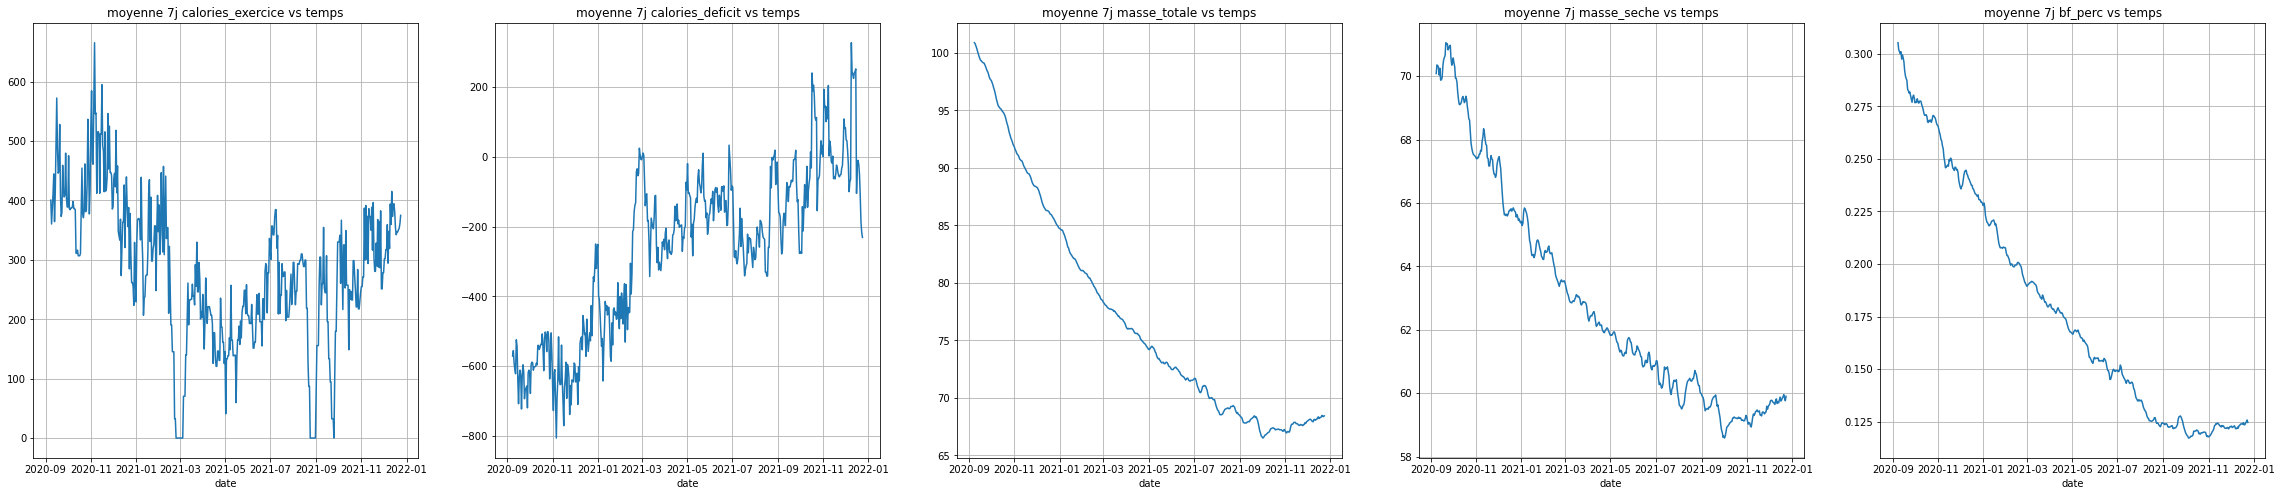

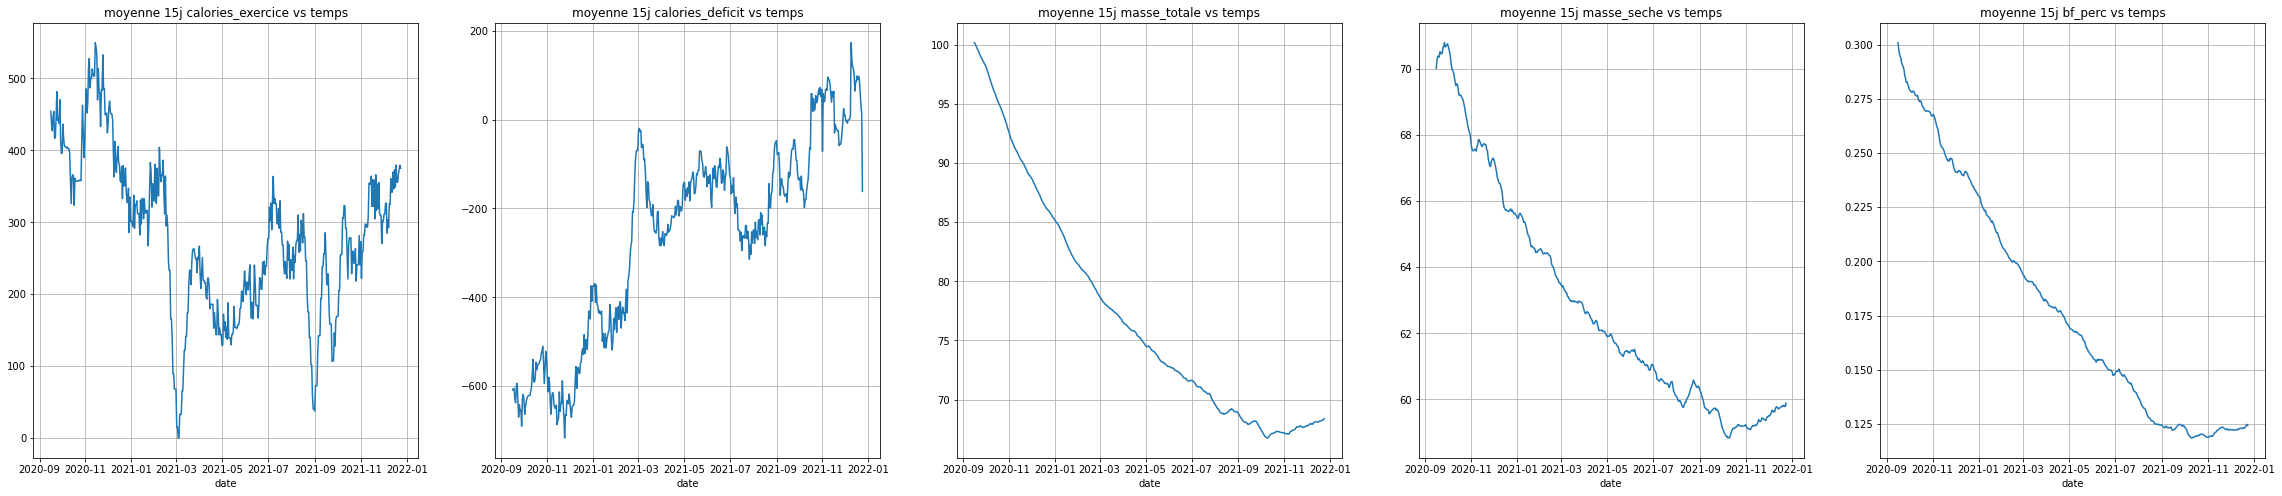

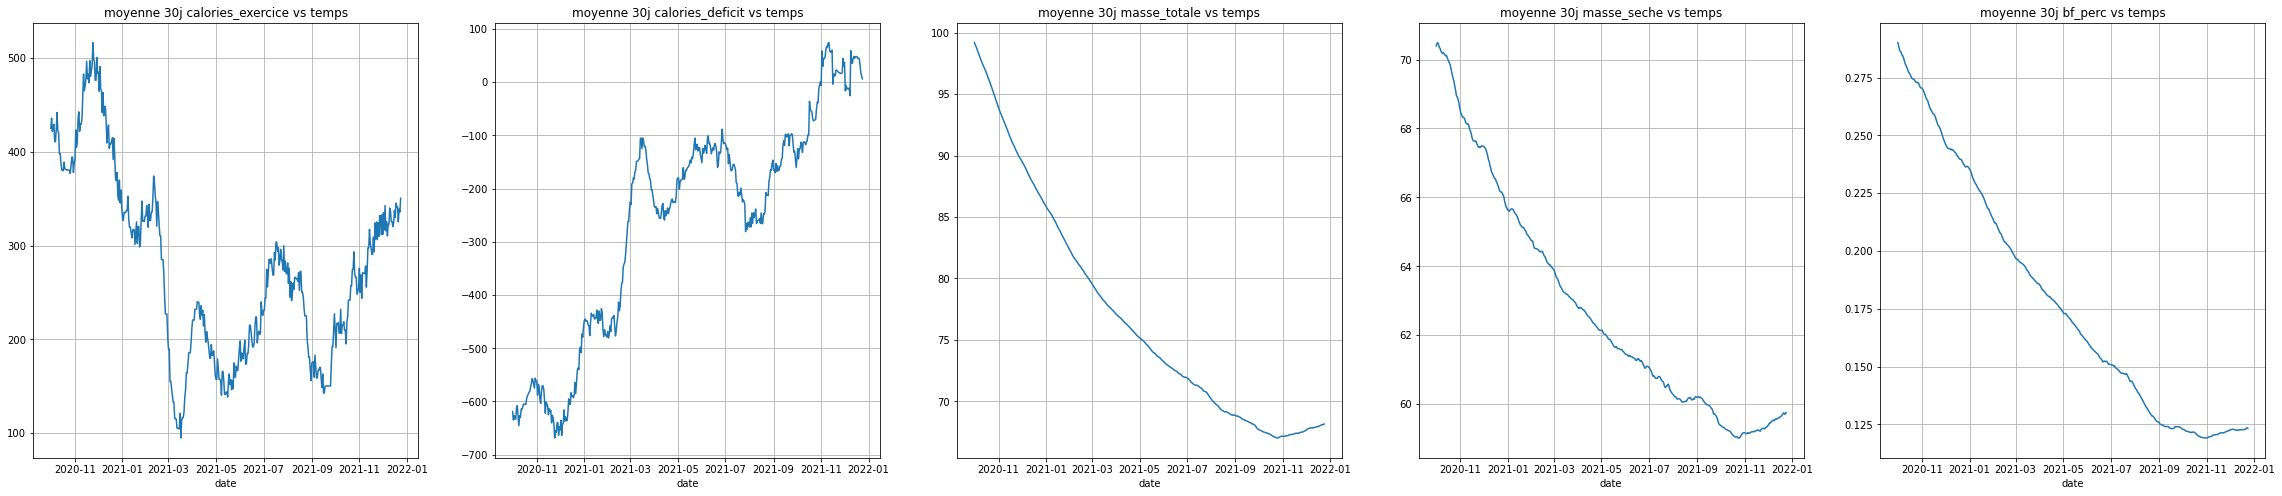

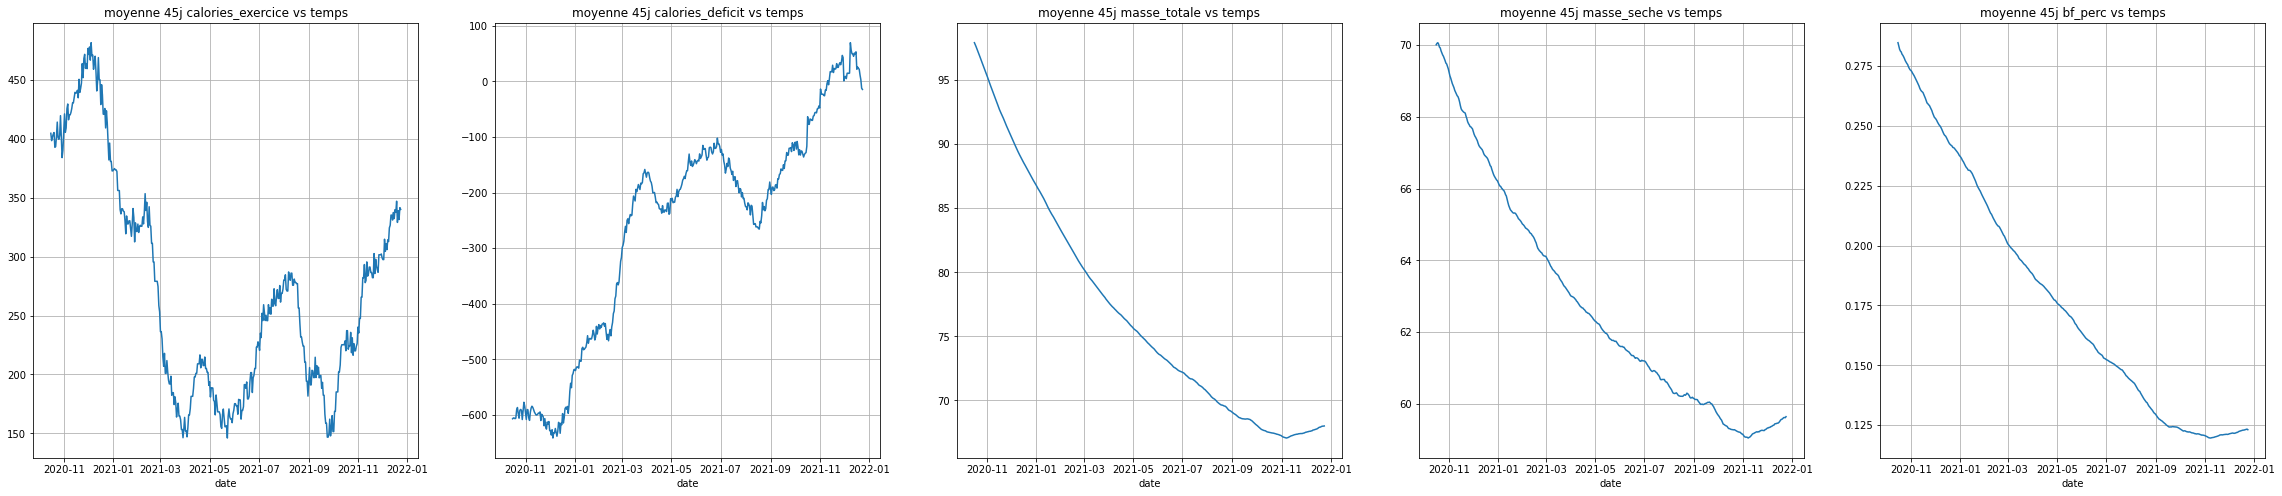

In [21]:
window_list = [7,15,30,45]

for w in window_list:
    wl.plot_moyennes(df, window=w)

In [22]:
over_last_days = 180

start_date = datetime.date.today() - datetime.timedelta(days = over_last_days)
index_to_drop = [df.index < start_date]

In [23]:
df_last = df.drop(index = df.index[index_to_drop])

C:\Users\benjamin.deporte\Anaconda3\envs\toy\lib\site-packages\pandas\core\indexes\base.py:4616: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


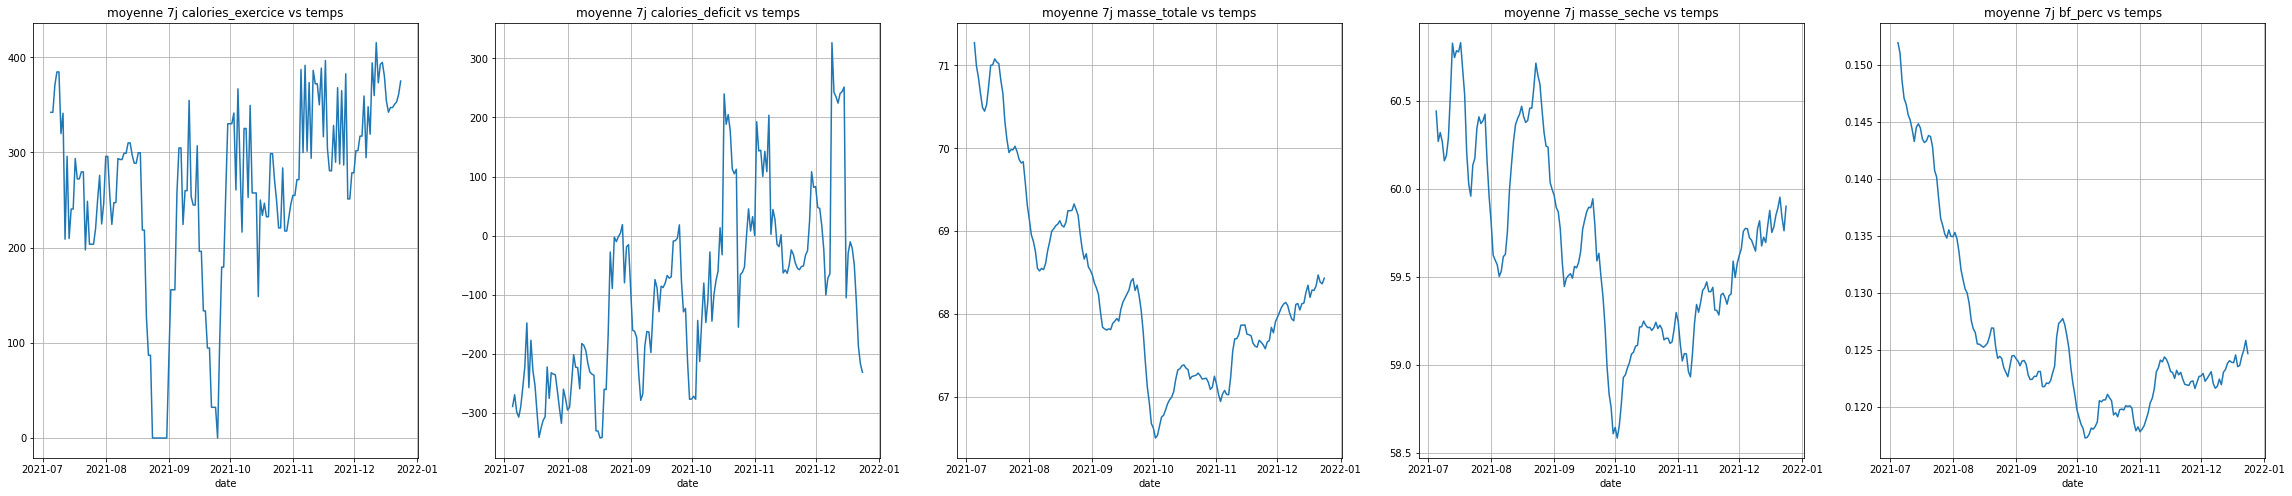

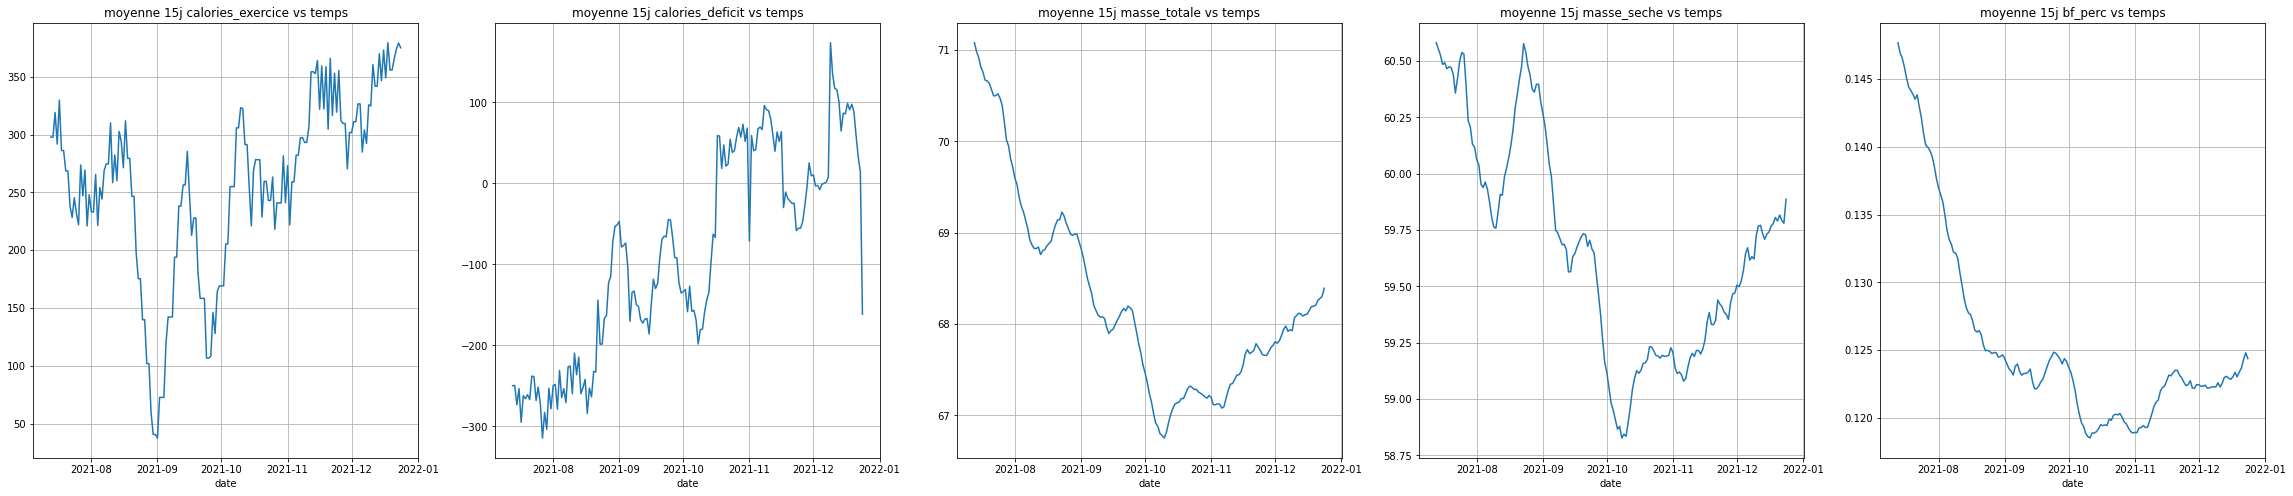

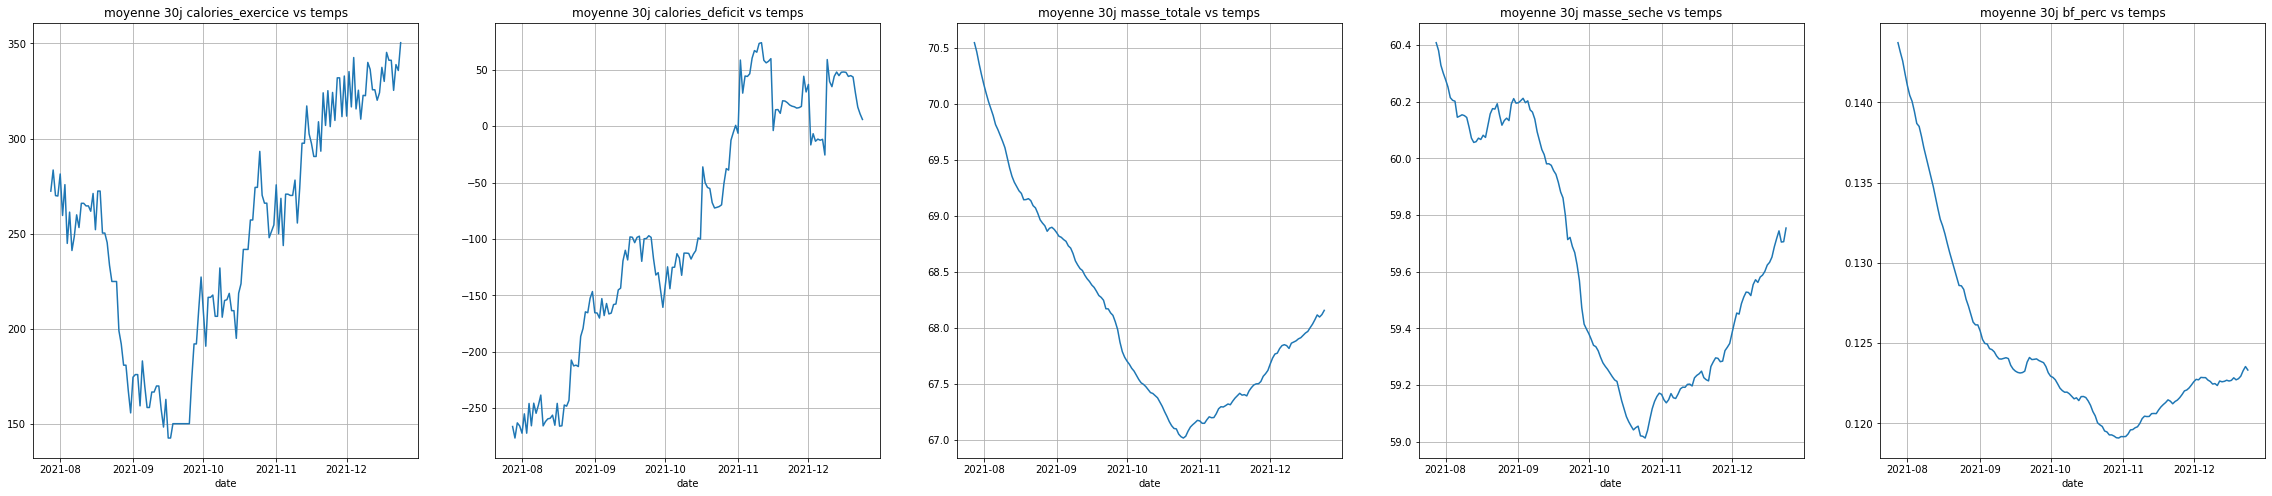

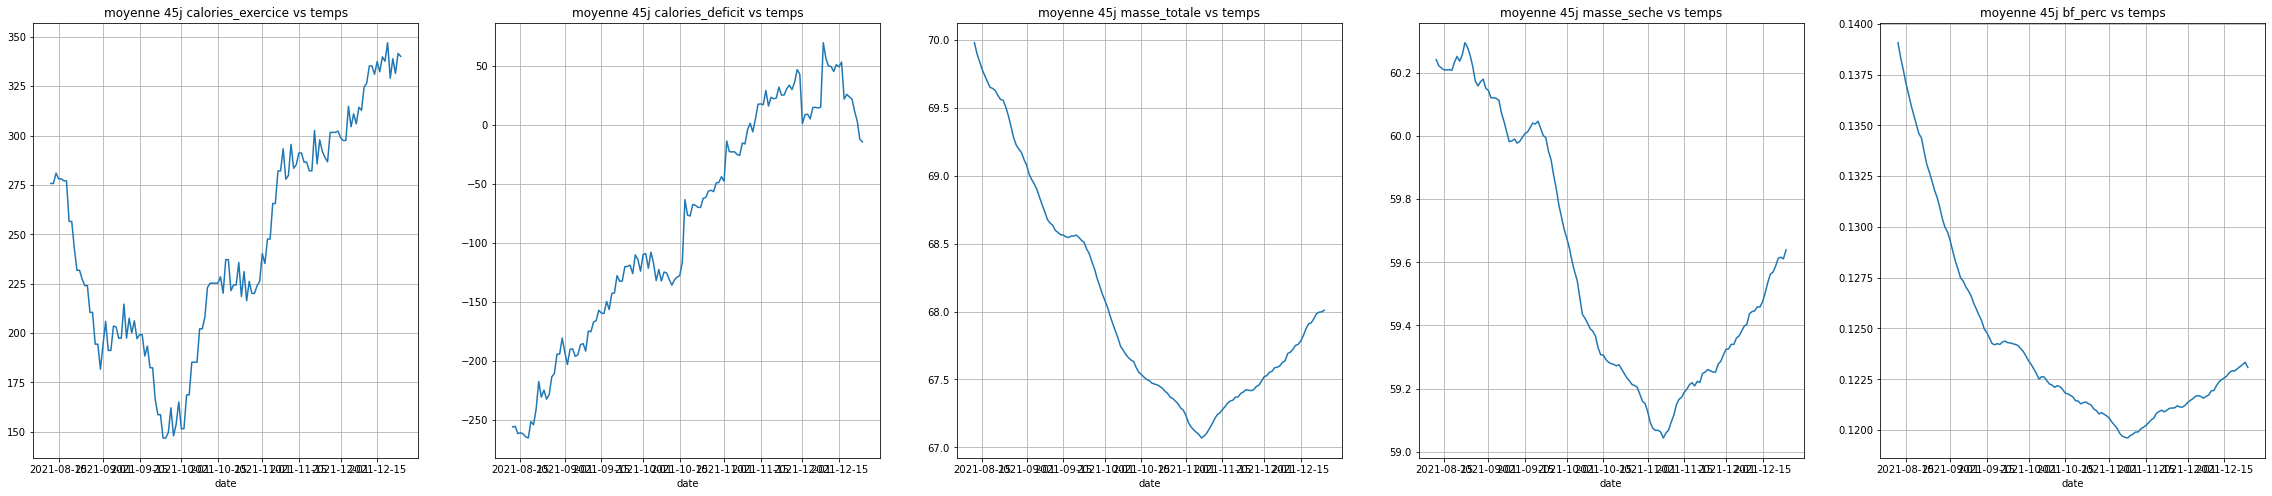

In [24]:
window_list = [7,15, 30, 45]

for w in window_list:
    wl.plot_moyennes(df=df_last, window=w)